In [1]:
import sys
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

In [2]:
class KalmanFilter: ###kf4init
    def __init__(self, envmap, init_pose, motion_noise_stds, distance_dev_rate=0.14, direction_dev=0.05): #変数追加
        self.belief = multivariate_normal(mean=np.array([0.0, 0.0, 0.0]), \
                                        cov=np.diag([1e-10, 1e-10, 1e-10])) 
        self.motion_noise_stds = motion_noise_stds
        self.map = envmap  #以下3行追加（Mclと同じ）
        self.distance_dev_rate = distance_dev_rate
        self.direction_dev = direction_dev
        
    def observation_update(self, observation):  #追加
        for d in observation:
            z = d[0]
            obs_id = d[1]
            
            ###Hの計算###
            mx, my = self.map.landmarks[obs_id].pos
            mux, muy, mut = self.belief.mean
            q = (mux - mx)**2 + (muy - my)**2
            sqrtq = np.sqrt(q)
            H = np.array([[(mux - mx)/sqrtq, (muy - my)/sqrtq, 0.0],  [(my - muy)/q, (mux - mx)/q, -1.0]])
            
            ###Qの計算###
            hmu = IdealCamera.relative_polar_pos(self.belief.mean, self.map.landmarks[obs_id].pos)
            distance_dev = self.distance_dev_rate*hmu[0]
            Q = np.diag(np.array([distance_dev**2, self.direction_dev**2]))
            
            ###カルマンゲインの計算###
            K = self.belief.cov.dot(H.T).dot(np.linalg.inv(Q + H.dot(self.belief.cov).dot(H.T)))
            
            ###更新###
            self.belief.mean += K.dot(z - hmu)
            self.belief.cov = (np.eye(3) - K.dot(H)).dot(self.belief.cov)
        
    def motion_update(self, nu, omega, time): 
        if abs(nu) < 1e-10 and abs(omega) < 1e-10:
            return

        v = self.motion_noise_stds
        M = np.diag([v["nn"]**2*abs(nu)/time + v["no"]**2*abs(omega)/time, 
                     v["on"]**2*abs(nu)/time + v["oo"]**2*abs(omega)/time])
        
        t = self.belief.mean[2]
        A = time * np.array([[math.cos(t), 0.0], [math.sin(t), 0.0], [0.0, 1.0]])
        
        G = np.diag([1.0, 1.0, 1.0])
        if abs(omega) < 10e-5:
            G[0, 2] = - nu * time * math.sin(t)
            G[1, 2] = nu * time * math.cos(t)
        else:
            G[0, 2] = nu / omega * (math.cos(t + omega * time) - math.cos(t))
            G[1, 2] = nu / omega * (math.sin(t + omega * time) - math.sin(t))
            
        self.belief.cov = G.dot(self.belief.cov).dot(G.T) + A.dot(M).dot(A.T)
        self.belief.mean = IdealRobot.state_transition(nu, omega, time, self.belief.mean)

    def draw(self, ax, elems):
        ###xy平面上での誤差楕円（3シグマ範囲）###
        eig_vals, eig_vec = np.linalg.eig(self.belief.cov[0:2, 0:2])
        ang = math.atan2(eig_vec[:,0][1], eig_vec[:,0][0])/math.pi*180
        e = Ellipse(self.belief.mean[0:2], width=3*eig_vals[0],height=3*eig_vals[1],
                       angle=ang, fill=False, color="blue", alpha=0.5)
        elems.append(ax.add_patch(e))

        ###θ方向の誤差の3シグマ範囲###
        x, y, c = self.belief.mean
        sigma3 = math.sqrt(self.belief.cov[2, 2])*3
        xs = [x + math.cos(c-sigma3), x, x + math.cos(c+sigma3)]
        ys = [y + math.sin(c-sigma3), y, y + math.sin(c+sigma3)]
        elems += ax.plot(xs, ys, color="blue", alpha=0.5)

In [3]:
class KfAgent(Agent): 
    def __init__(self, time_interval, nu, omega, init_pose, envmap, \
                motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}):
        super().__init__(nu, omega)
        self.kf = KalmanFilter(envmap, init_pose, motion_noise_stds) 
        self.time_interval = time_interval
        
    def decision(self, observation=None):  ###kfagent2
        self.kf.motion_update(self.nu, self.omega, self.time_interval)
        self.kf.observation_update(observation)   #追加
        return self.nu, self.omega
        
    def draw(self, ax, elems): #追加
        self.kf.draw(ax, elems)

<IPython.core.display.Javascript object>


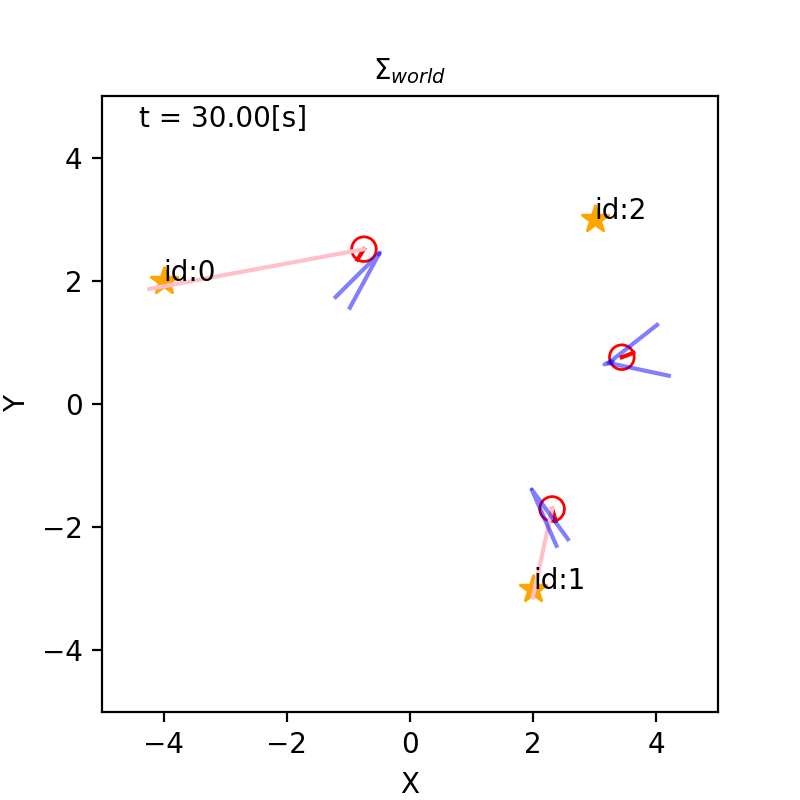

In [4]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = World(30, time_interval) 

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()                                  
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ### ロボットを作る ###
    circling = KfAgent(time_interval, 0.2, 10.0/180*math.pi, np.array([0, 0, 0]).T, m)
    r = Robot(np.array([0, 0, 0]).T, sensor=Camera(m), agent=circling, color="red")
    world.append(r)
    linear = KfAgent(time_interval, 0.1, 0.0, np.array([0, 0, 0]).T, m)
    r = Robot(np.array([0, 0, 0]).T, sensor=Camera(m), agent=linear, color="red")
    world.append(r)
    right = KfAgent(time_interval, 0.1, -3.0/180*math.pi, np.array([0, 0, 0]).T, m)
    r = Robot(np.array([0, 0, 0]).T, sensor=Camera(m), agent=right, color="red")
    world.append(r)

    world.draw()                       # アニメーションさせるとき
   # r.one_step(time_interval)  # アニメーションなしでデバッグするとき